# <center><font color=#76B900 size="+3"><b>**Running NVIDIA cuOpt with additional constraints (CVRPTW)**</b></font></center>
---

**Learning Objectives:**
- Modeling of a Capacitated Vehicle Routing Problem with Time Windows (CVRPTW)
- Introduction to more advanced real world constraints

Your company has expanded beyond professional services and now also delivers and installs hardware on-site.  From all your experience you are now able to accurately estimate how much time a given job will take and want to give each customer an opportunity to specify time windows during which they will be available. In addition to the benefits for your customers, you also want to allow for some flexibility as to when each employee is available to work.
<br>
<center><img src=https://raw.githubusercontent.com/rgsl888prabhu/Images/master/nvidia_reopt_route.png width=600> </center>

**The company is now dealing with the following CVRPTW problem:**
- 8 Locations:
    - 1 Depot (e.g. Office or Warehouse)
    - 7 (Clients/Customer)
- 5 Vehicles in the Fleet
- Each vehicle has associated capacities
- Each location has a specific time window within which services/deliveries need to be performed
- Demand for hardware may differ across locations
- Each vehicle has a time window of its availability

In [1]:
from cuopt import routing
import cudf
import pandas as pd
from scipy.spatial import distance
import helper_function.helper_map as helper_map

## Problem Definition

In [2]:
location_names       = [ "Depot",   "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [ [4, 4],   [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3]]

# Units of hardware to be delivered at each location, this can be number of orders, weight or volume.
orders               = [   0,        3,      4,      4,      3,      4,      3,      2   ]
# Earliest a delivery can be made
l_tw_earliest        = [   0,        3,      5,      3,      1,      8,      4,      0   ]
# Latest a delivery can be made
l_tw_latest          = [1000,       20,     30,     15,     20,     12,     40,     30   ]
# Service time required for the delivery/service
l_tw_service         = [   0,         1,     1,      1,       1,     2,      3,      1   ]
n_locations           = len(location_coordinates)
n_vehicles           = 5
# Number of orders each vehicle can carry, this can be number of orders, weight or volumne
vehicle_capacity     = [5,  7,  5,  8,  6]
# Earliest a vehicle can start 
v_tw_earliest        = [0,  1,  3,  5,  20]
# Latest a vehicle will be working
v_tw_latest          = [80, 40, 30, 80, 100]

vehicle_colors       = ["blue", "white", "green", "pink", "yellow"] # Used to identify differnt vehicle 

location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)

location_coordinates_df

,xcord,ycord
Depot,4,4
A,1,3
B,8,1
C,2,1
D,6,7
E,0,2
F,7,6
G,5,3


### Visualize Depot and Destinations

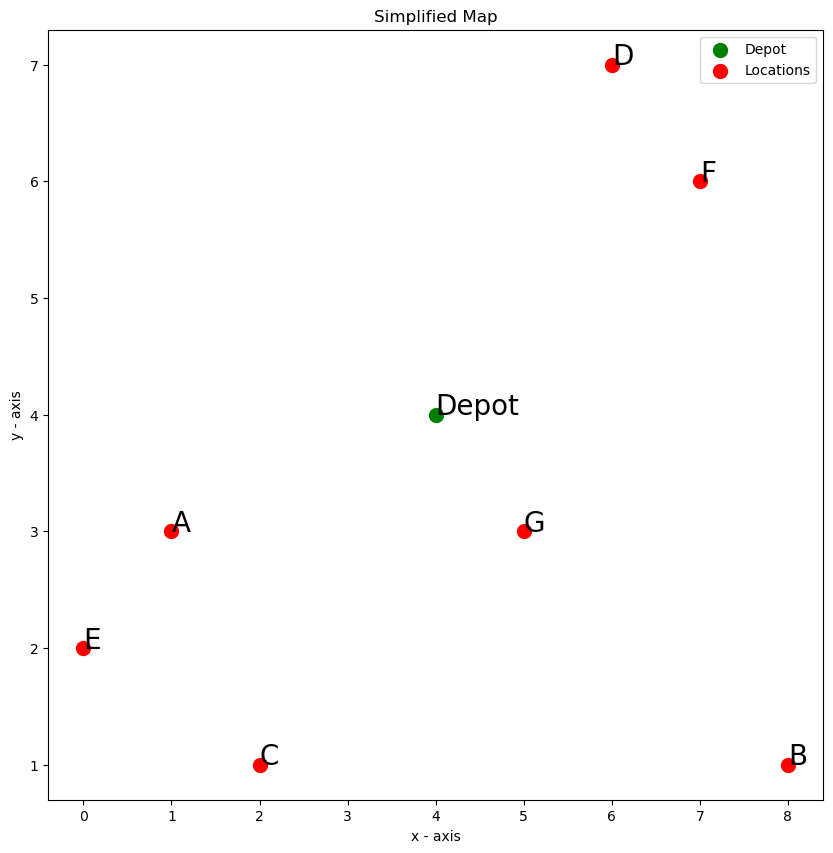

In [3]:
helper_map.gen_plot(location_coordinates_df).show()

The **cost matrix** models the cost between each pair of locations.  It is used by NVIDIA cuOpt to compute the cost of traveling from any location to any other.  Here we are going to specify that distance traveled is the cost we are looking to minimize. 

Let's create a distance based cost matrix (called `distance_matrix`)from the location coordinates dataframe, and let the distance between locations be measured by a `euclidean` metric. This will result in a symmetric distance matrix [ distance(A, B) == distance(B, A) ] which is an ideal case. However, in general NVIDIA cuOpt also supports asymmetric matrices which is especially useful when dealing with real-world problems.

In [4]:
distance_matrix = distance.cdist(location_coordinates_df.values, location_coordinates_df.values, "euclidean")

# Let's create a dataframe of this matrix
distance_matrix  = cudf.DataFrame(distance_matrix, index=location_coordinates_df.index, columns=location_coordinates_df.index)
for ar in distance_matrix.values:
    print([round(i.item(),1) for i in ar])

[0.0, 3.2, 5.0, 3.6, 3.6, 4.5, 3.6, 1.4]
[3.2, 0.0, 7.3, 2.2, 6.4, 1.4, 6.7, 4.0]
[5.0, 7.3, 0.0, 6.0, 6.3, 8.1, 5.1, 3.6]
[3.6, 2.2, 6.0, 0.0, 7.2, 2.2, 7.1, 3.6]
[3.6, 6.4, 6.3, 7.2, 0.0, 7.8, 1.4, 4.1]
[4.5, 1.4, 8.1, 2.2, 7.8, 0.0, 8.1, 5.1]
[3.6, 6.7, 5.1, 7.1, 1.4, 8.1, 0.0, 3.6]
[1.4, 4.0, 3.6, 3.6, 4.1, 5.1, 3.6, 0.0]


<br>

## Create Data-Model
---
Create a Data model with the following:
 - Number of locations
 - Number of vehicles in the fleet
 - Cost matrix
 - Location time windows
 - Vehicle time windows
 - Vehicle capacities
 - Variable demand across locations

In [5]:
data_model = routing.DataModel(n_locations, n_vehicles)
data_model.add_cost_matrix(distance_matrix)
data_model.add_capacity_dimension(
    "hardware_demand",
    cudf.Series(orders),
    cudf.Series(vehicle_capacity)
)
data_model.set_order_time_windows(
    cudf.Series(l_tw_earliest),
    cudf.Series(l_tw_latest), 
)

data_model.set_order_service_times(
    cudf.Series(l_tw_service)
)

data_model.set_vehicle_time_windows(
    cudf.Series(v_tw_earliest), 
    cudf.Series(v_tw_latest)
)


<br>

## Create Solver Instance
---
The solver instance will take the data-model and return an optimized route plan. Additional configuration options are available to further customize solver behavior including: 
- The number of parallel agents (climbers) examining the solution search space
- The maximum time allotted to find a solution
- The minimum number of vehicles to be used
- and more

In [6]:
solver_settings = routing.SolverSettings()
# set number of climbers that will try to search for an optimal path parallely
solver_settings.set_number_of_climbers(64)
# solver will run for given time limit and it will fail if needs more time
solver_settings.set_time_limit(0.01)
# Set minimum number of vehciles that need to be used to compute results
# solver.set_min_vehicles(5)
routing_solution = routing.Solve(data_model, solver_settings)
if routing_solution.get_status() == 0:
    print("Solution Found")
else:
    print("No Solution Found")

Solution Found


<br>

## CVRPTW Results
---

In [7]:
if routing_solution.get_status() == 0:
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    helper_map.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in distance:  34.90481185913086
Vehicle count to complete routing:  4
For vehicle - 0 route is: 

Depot->C->Depot


For vehicle - 1 route is: 

Depot->F->D->Depot


For vehicle - 3 route is: 

Depot->E->A->Depot


For vehicle - 4 route is: 

Depot->G->B->Depot




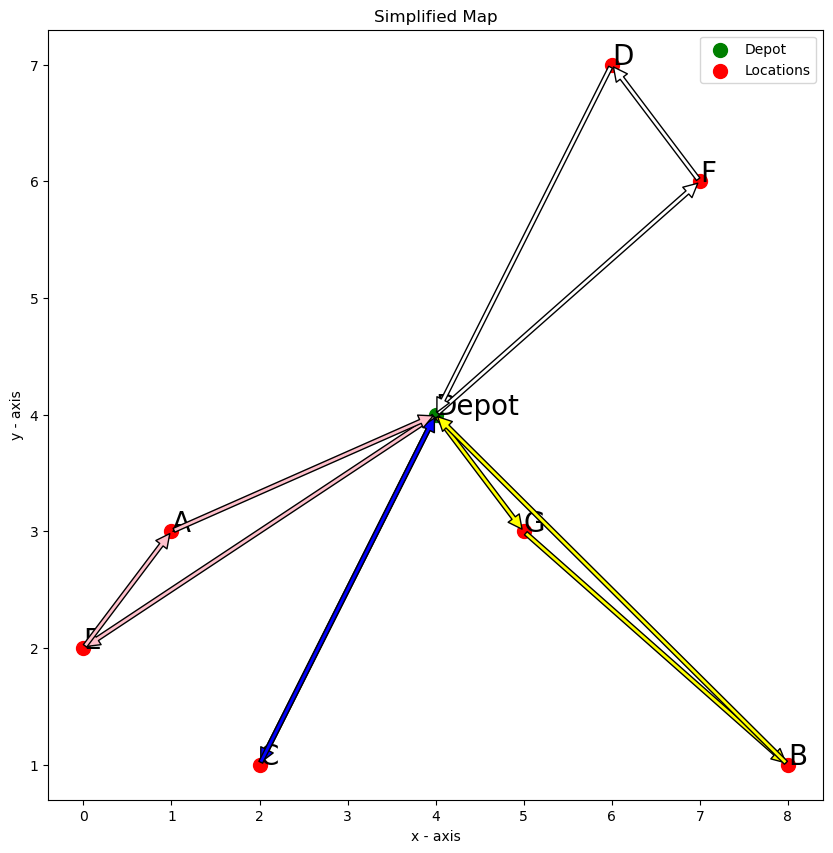

In [8]:
helper_map.map_vehicle_routes(location_coordinates_df, routing_solution.route, vehicle_colors).show()

**NOTE:** Because we did not specify that NVIDIA cuOpt should use the entire fleet of 5 vehicles, the solution that was returned was for 4 vehicles.  By default, NVIDIA cuOpt seeks to minimize the number of vehicles used if possible as that is typically the largest expense in these types of problems.  You can uncomment the `min_vehicle` constraint if you wish to see the 5 vehicle solution.

In [9]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}


## What's Next?

#### A short `CVRPTW` exercise to get more familiar with Nvidia cuOpt. [please click to continue](./04_cvrptw_exercise_cuopt.ipynb) 

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>